<a href="https://colab.research.google.com/github/PeerChristensen/FlowerImageClassifier/blob/main/src/basic_fastai_mushroom_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mushroom image scraping and cladsification with fastai

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

## Step 1: Download images

In [3]:
!pip install duckduckgo_search

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 96 kB 5.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a cantarel photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [28]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('Boletus badius photos', max_images=1)
urls[0]

Searching for 'Boletus badius photos'


'https://identifier-les-champignons.com/wp-content/uploads/2020/06/Boletus_badius_stem-scaled.jpg'

...and then download a URL and take a look at it:

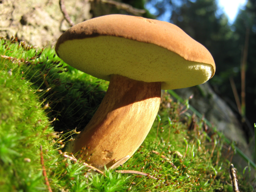

In [29]:
from fastdownload import download_url
dest = 'boletus_badius.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "Dog photos":

Searching for 'dog photo'


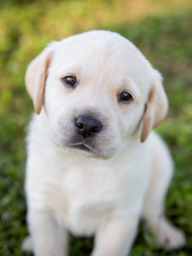

In [7]:
download_url(search_images('dog photo', max_images=1)[0], 'Dog.jpg', show_progress=False)
Image.open('Dog.jpg').to_thumb(256,256)


Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [8]:
import pandas as pd
import random

df = pd.read_csv("danish_mushrooms.csv")

searches = df.lat_name.to_list()

path = Path('mushrooms')
from time import sleep

In [9]:
for n,o in enumerate(searches):
    print(f"{n+1} of {len(searches)}")
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(2)  # Pause between searches to avoid over-loading server
    #download_images(dest, urls=search_images(f'{o} sun photo'))
    #sleep(2)
    #download_images(dest, urls=search_images(f'{o} shade photo'))
    #sleep(2)
    #resize_images(path/o, max_size=400, dest=path/o)
    
print("\nDONE!")

1 of 82
Searching for 'Agaricus arvensis'
2 of 82
Searching for 'Coprinopsis atramentaria'
3 of 82
Searching for 'Cantharellus cibarius'
4 of 82
Searching for 'Paxillus involutus'
5 of 82
Searching for 'Hygrophoropsis aurantiaca'
6 of 82
Searching for 'Hydnum repandum'
7 of 82
Searching for 'Phallus impudicus'
8 of 82
Searching for 'Pleurotus ostreatus'
9 of 82
Searching for 'Russula claroflava'
10 of 82
Searching for 'Hydnellum peckii'
11 of 82
Searching for 'Sparassis crispa'
12 of 82
Searching for 'Sarcodon scabrosus'
13 of 82
Searching for 'Trametes versicolor'
14 of 82
Searching for 'Russula cyanoxantha'
15 of 82
Searching for 'Leccinum scabrum'
16 of 82
Searching for 'Amanita fulva'
17 of 82
Searching for 'Suillus luteus'
18 of 82
Searching for 'Boletus badius'
19 of 82
Searching for 'Pseudohydnum gelatinosum'
20 of 82
Searching for 'Creolophus cirrhatus'
21 of 82
Searching for 'Marasmius oreades'
22 of 82
Searching for 'Paxillus filamentosus'
23 of 82
Searching for 'Boletus subt

In [10]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r './mushrooms' /content/drive/MyDrive/mushrooms/

Mounted at /content/drive


## Step 2: Train our model

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

51

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

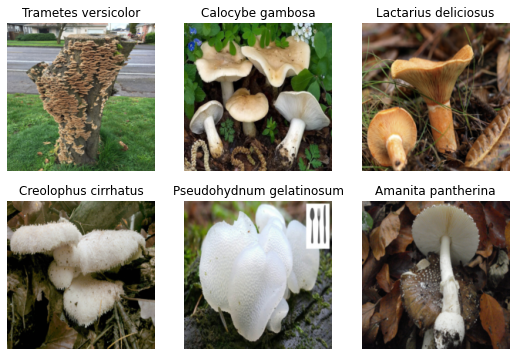

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')] # or crop or pad
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. Other options are ResNet-18, ResNet-34, ResNet-50, ResNet-101, ResNet-110, ResNet-152, ResNet-164, ResNet-1202
Remember to use GPU.

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [40]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(7)

# resnet 18, 5 eps, err rate = .398
# resnet 50, 7 eps, err rate = .351

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,3.777481,2.114180,0.529183,03:17


epoch,train_loss,valid_loss,error_rate,time
0,1.719823,1.613533,0.421530,03:17
1,1.107687,1.618144,0.408560,03:14
2,0.677883,1.537311,0.391699,03:17
3,0.298918,1.428720,0.367056,03:15
4,0.117752,1.394187,0.361868,03:18
5,0.051049,1.372062,0.348898,03:15
6,0.031640,1.388838,0.351492,03:15


In [41]:
learn.export('mushroom_model_rn50_7eps.pkl')

#from google.colab import files
#files.download("mushroom_model_rn18_5eps.pkl")
!cp -r './mushroom_model_rn50_7eps.pkl' /content/drive/MyDrive/mushrooms/



In [ ]:
'''import os
#os.chdir(r'/kaggle/working')

!tar -czf flowers100_50each.tar.gz flowers

from IPython.display import FileLink

FileLink(r'flowers100_50each.tar.gz')
files.download("flowers100_50each.tar.gz")

'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [15]:
learn.dls.vocab

['Agaricus arvensis', 'Agaricus augustus', 'Agaricus bisporus', 'Agaricus campestris', 'Agaricus sylvaticus', 'Agaricus sylvicola', 'Agaricus xanthoderma', 'Amanita excelsa', 'Amanita fulva', 'Amanita muscaria', 'Amanita pantherina', 'Amanita phalloides', 'Amanita rubescens', 'Amanita virosa', 'Auricularia auricula-judae', 'Auriscalpium vulgare', 'Bankera fuligineoalba', 'Boletus badius', 'Boletus chrysenteron', 'Boletus edulis', 'Boletus luridiformis', 'Boletus luridus', 'Boletus reticulatus', 'Boletus satanas', 'Boletus subtomentosus', 'Calocybe gambosa', 'Cantharellus cibarius', 'Cantharellus tubaeformis', 'Chlorophyllum olivieri', 'Clitocybe nebularis', 'Coprinopsis atramentaria', 'Coprinus comatus', 'Cortinarius rubellus', 'Craterellus cornucopioides', 'Creolophus cirrhatus', 'Entoloma eulividum', 'Flammulina velutipes', 'Fomes fomentarius', 'Fomitopsis pinicola', 'Galerina marginata', 'Gyromitra esculenta', 'Hericium coralloides', 'Hydnellum peckii', 'Hydnum repandum', 'Hygrophor

In [48]:
#print(len(dls.vocab))

label_ind = [x for x,element in enumerate(learn.dls.vocab) if element == "Boletus badius"][0]
print(label_ind)

17


In [49]:
pred,_,probs = learn.predict(PILImage.create('boletus_badius.jpg'))
print(f"This is an: {pred}.")
print(f"Probability: {probs[label_ind]:.4f}")
print()

This is an: Boletus badius.
Probability: 0.9989



## Performance

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

In [43]:
interp = ClassificationInterpretation.from_learner(learn)

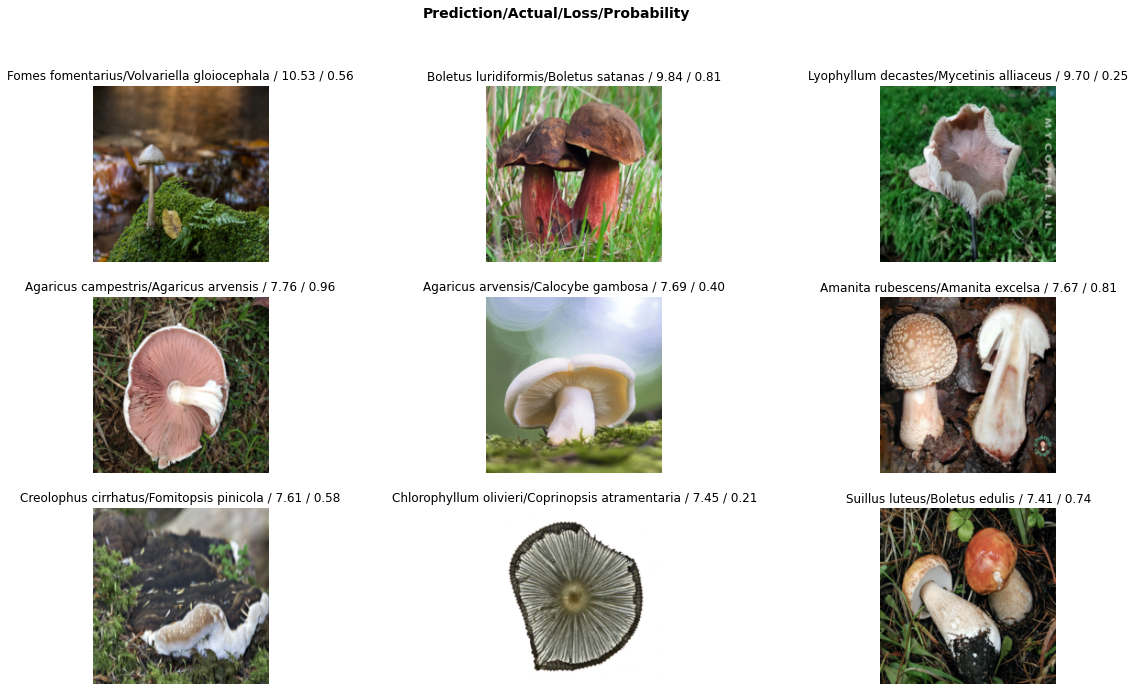

In [35]:
interp.plot_top_losses(9, figsize=(20,11))

In [36]:
interp.most_confused(min_val=2)

[('Russula emetica', 'Russula paludosa', 6),
 ('Russula ochroleuca', 'Russula claroflava', 6),
 ('Boletus edulis', 'Boletus reticulatus', 5),
 ('Russula claroflava', 'Russula ochroleuca', 4),
 ('Agaricus xanthoderma', 'Agaricus arvensis', 3),
 ('Amanita excelsa', 'Amanita pantherina', 3),
 ('Amanita excelsa', 'Amanita rubescens', 3),
 ('Boletus luridiformis', 'Boletus luridus', 3),
 ('Paxillus filamentosus', 'Lactarius deliciosus', 3),
 ('Paxillus involutus', 'Lactarius torminosus', 3),
 ('Agaricus bisporus', 'Agaricus arvensis', 2),
 ('Agaricus campestris', 'Agaricus xanthoderma', 2),
 ('Agaricus sylvicola', 'Agaricus xanthoderma', 2),
 ('Agaricus xanthoderma', 'Agaricus sylvicola', 2),
 ('Amanita excelsa', 'Clitocybe nebularis', 2),
 ('Amanita phalloides', 'Amanita virosa', 2),
 ('Amanita virosa', 'Agaricus arvensis', 2),
 ('Amanita virosa', 'Volvariella gloiocephala', 2),
 ('Boletus badius', 'Boletus reticulatus', 2),
 ('Boletus chrysenteron', 'Boletus subtomentosus', 2),
 ('Boletus

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.

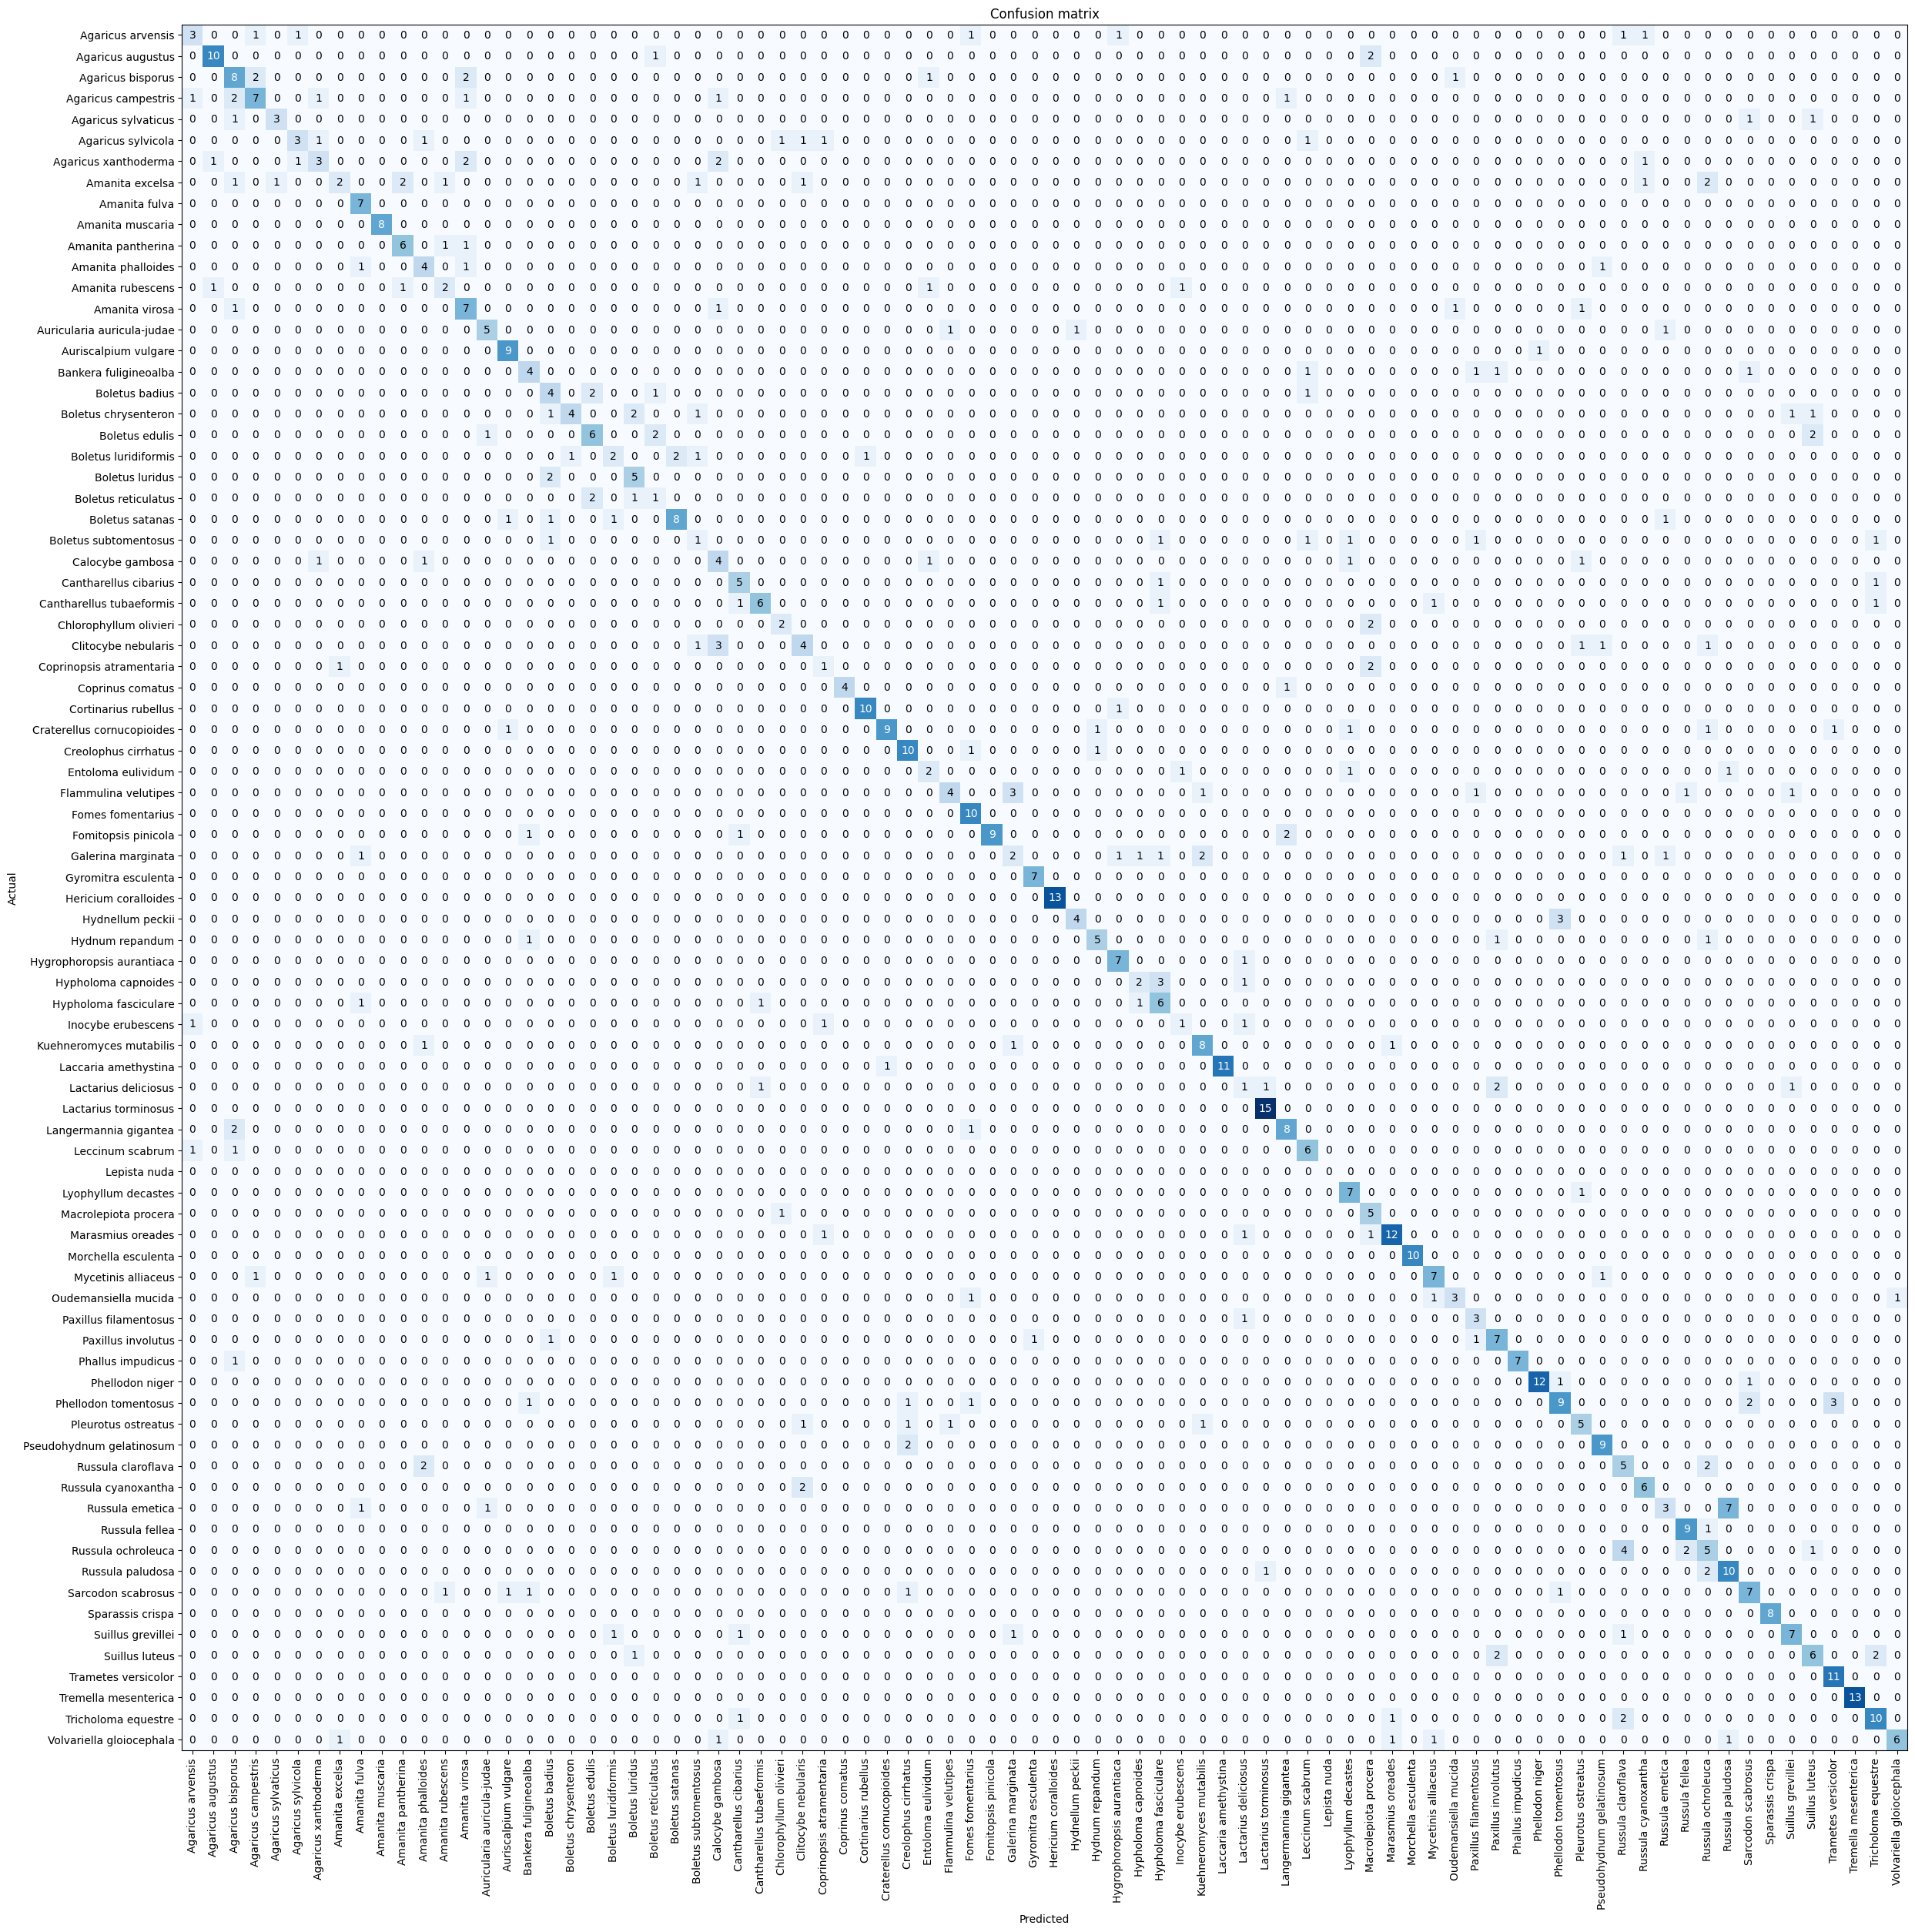

In [44]:
interp.plot_confusion_matrix(figsize=(25,25), dpi=100)